In [1]:
import tensorflow as tf

print(tf.__version__)

2.1.0


In [2]:
import tensorflow_datasets as tfds

print(tfds.__version__)

1.3.2


# Load data

In [3]:
datasets, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

In [4]:
info.features, info.splits

(FeaturesDict({
     'file_name': Text(shape=(), dtype=tf.string),
     'image': Image(shape=(None, None, 3), dtype=tf.uint8),
     'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
     'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
 }),
 {'test': <tfds.core.SplitInfo num_examples=3669>,
  'train': <tfds.core.SplitInfo num_examples=3680>})

In [10]:
ds_train, ds_test = datasets["train"], datasets["test"]

# Pre-process data

In [11]:
IMG_SIZE = 128

In [12]:
@tf.function
def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.
    mask -= 1 # data is labelled as 1 2 3, subtract 1 to have 0, 1, 2
    return image, mask

@tf.function
def prepare_train_image(data):
    image = tf.image.resize(data['image'], (IMG_SIZE, IMG_SIZE))
    mask = tf.image.resize(data['segmentation_mask'], (IMG_SIZE, IMG_SIZE), method='nearest')
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    
    image, mask = normalize(image, mask)
    return image, mask

@tf.function
def prepare_test_image(data):
    image = tf.image.resize(data['image'], (IMG_SIZE, IMG_SIZE))
    mask = tf.image.resize(data['segmentation_mask'], (IMG_SIZE, IMG_SIZE), method='nearest')
        
    image, mask = normalize(image, mask)
    return image, mask

In [13]:
ds_train = ds_train.map(prepare_train_image, tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(prepare_test_image, tf.data.experimental.AUTOTUNE)

In [14]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [15]:
ds_train = ds_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [16]:
ds_test = ds_test.batch(BATCH_SIZE)

# Visualize data

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

def display(display_list, title = ['Input Image', 'True Mask', 'Predicted Mask']):
    plt.figure(figsize=(15, 15))
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show

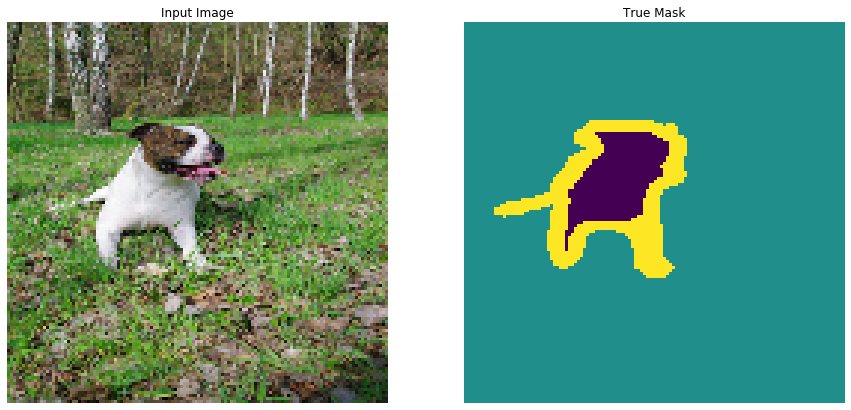

In [24]:
for image, mask in ds_train.take(1):
    display([image[0], mask[0]])

# Model

In [25]:
OUTPUT_CHANNELS = 3

In [26]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [27]:
def upsample_bn_relu(filters, size, apply_dropout=False):
    '''https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py#L220'''
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [28]:
up_stack = [
    upsample_bn_relu(512, 3),  # 4x4 -> 8x8
    upsample_bn_relu(256, 3),  # 8x8 -> 16x16
    upsample_bn_relu(128, 3),  # 16x16 -> 32x32
    upsample_bn_relu(64, 3),   # 32x32 -> 64x64
]

In [30]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128
    
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [31]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Visualize output

In [33]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

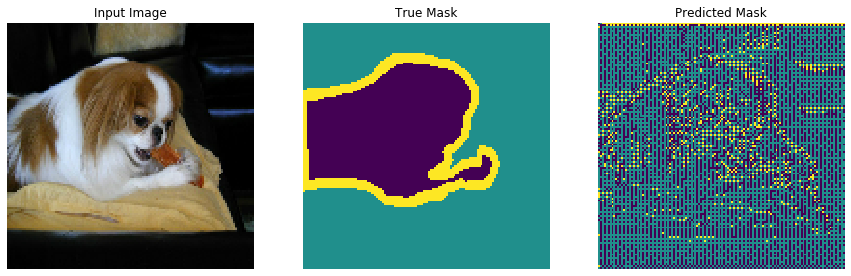

In [34]:
show_predictions(ds_train)

# Display Callback

In [42]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(ds_train)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# Train


Sample Prediction after epoch 20

57/57 [==============================] - 11s 198ms/step - loss: 0.0668 - accuracy: 0.9722 - val_loss: 0.5398 - val_accuracy: 0.8821


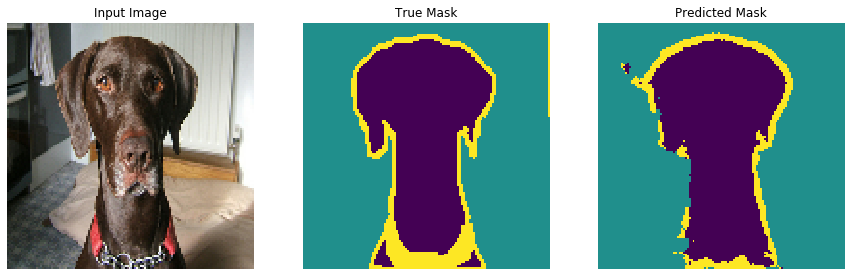

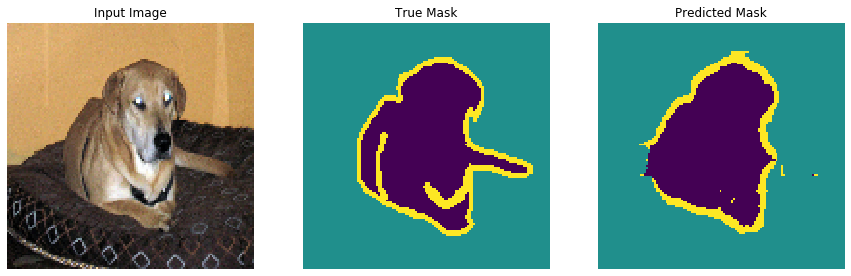

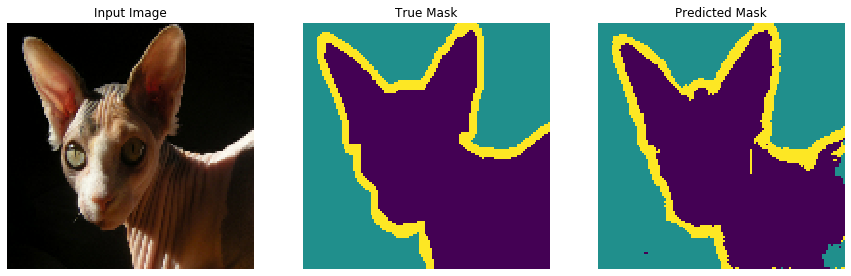

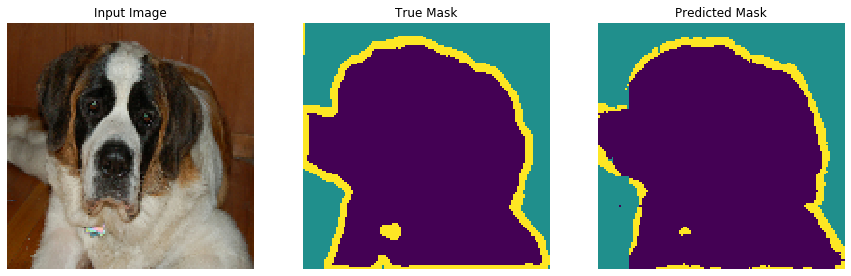

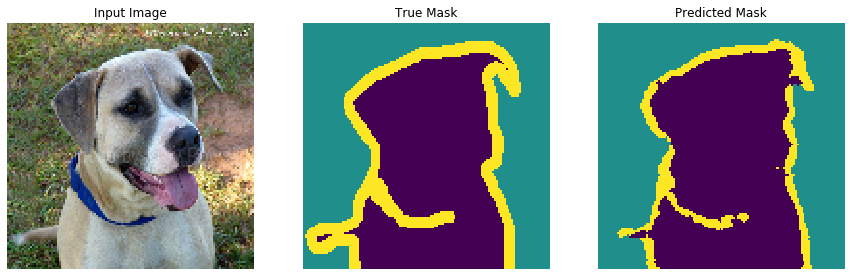

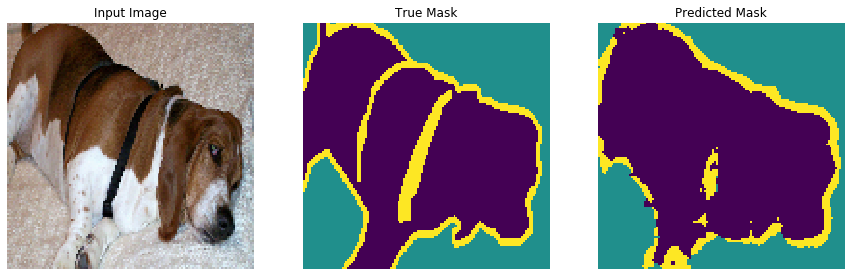

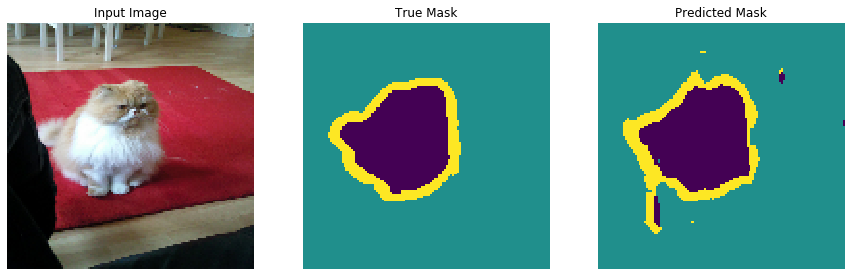

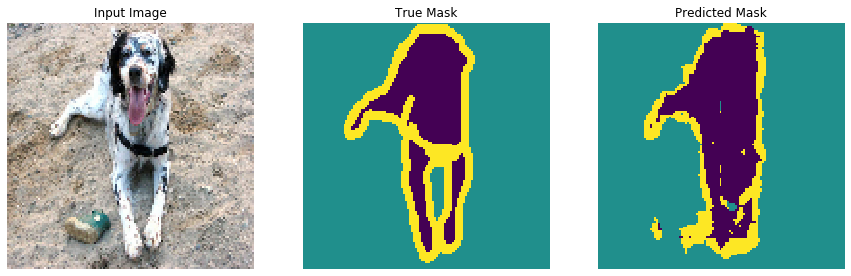

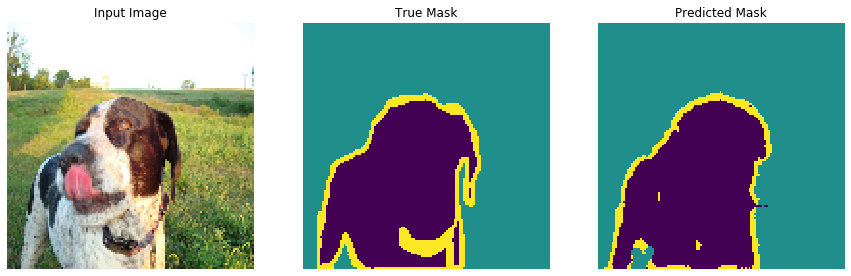

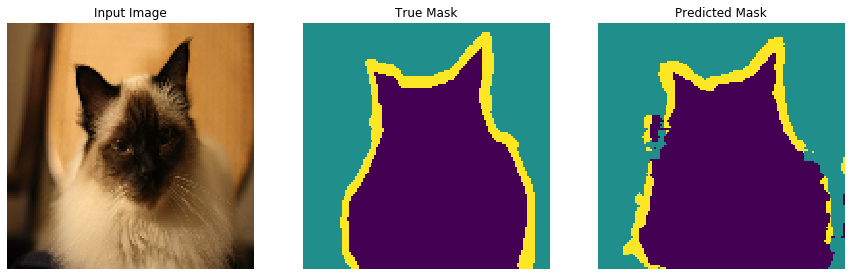

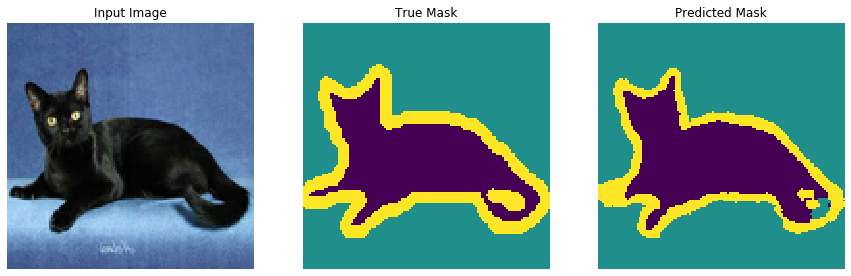

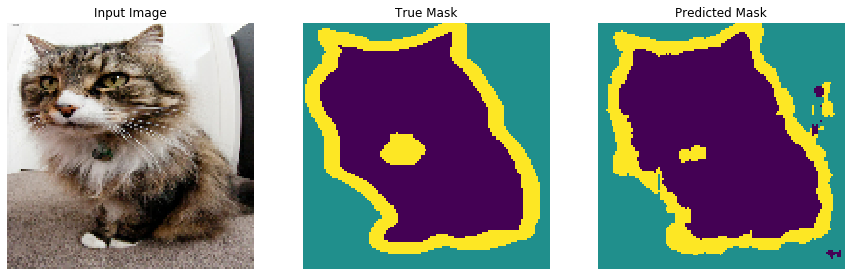

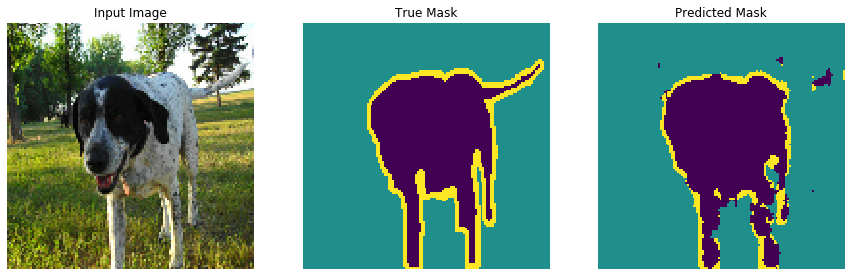

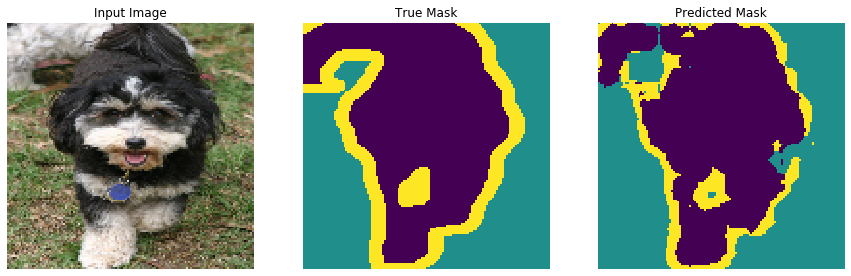

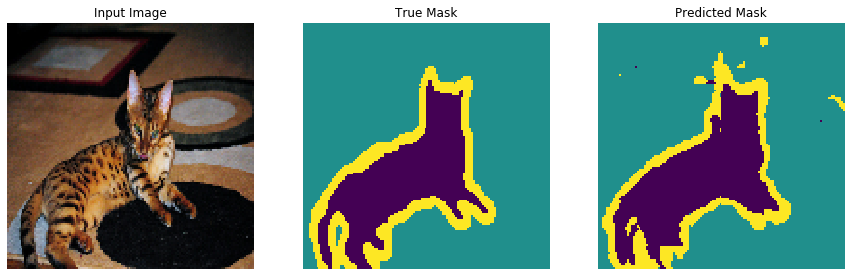

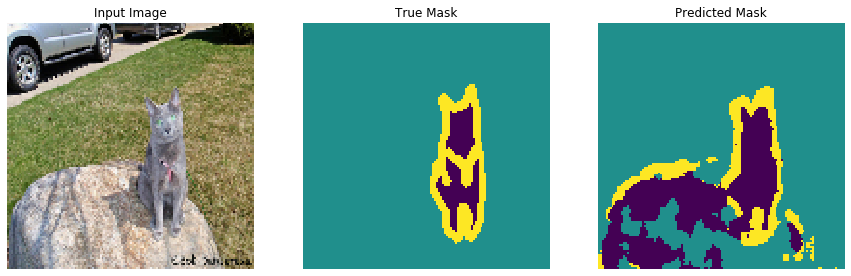

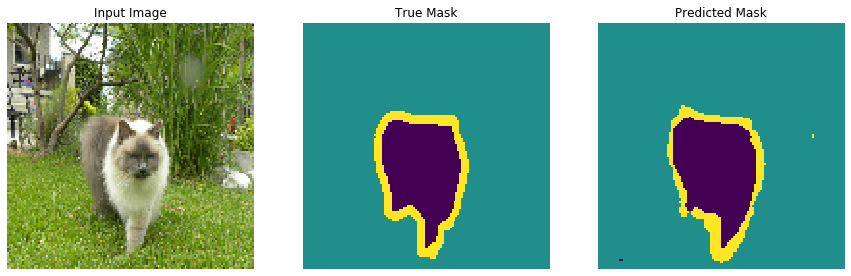

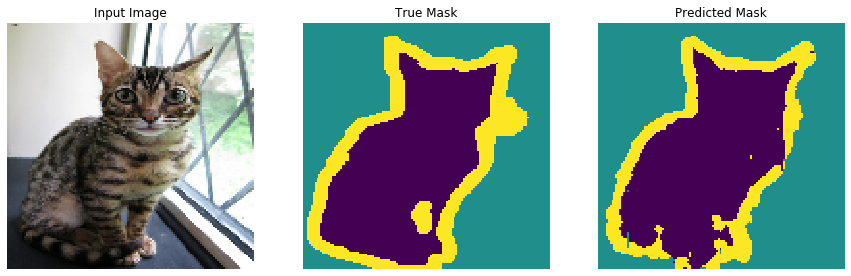

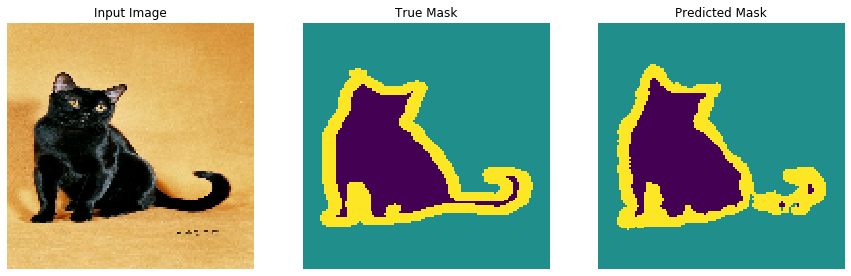

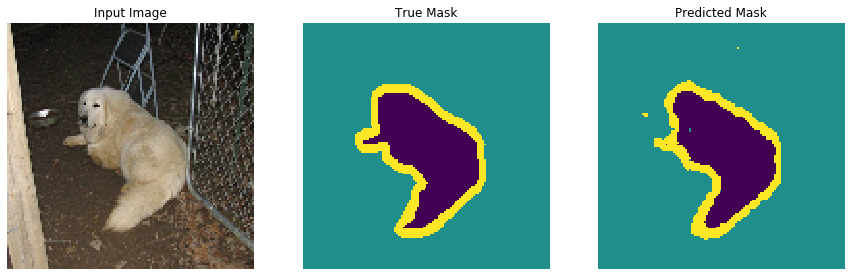

In [44]:
EPOCHS = 20
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(ds_train, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=ds_test,
                          callbacks=[DisplayCallback()])